Importing & reading in data

In [1]:
from requests import get
from pandas import DataFrame, concat, to_datetime, to_timedelta, json_normalize, notna, isna
from time import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3
from math import ceil
from plotly.graph_objects import Scatter
import plotly.figure_factory as ff
from plotly.express import colors
from dotenv import load_dotenv
import json

In [2]:
load_dotenv()

import os
domain = os.getenv("URL")
print('Getting data... Please wait!')
startTime = time()

# get sale data
response = get('https://' + domain + 'sale')
saleData = response.json()

print('Took', round(time() - startTime, 2), 'seconds to get Sale data.')

Getting data... Please wait!
Took 26.24 seconds to get Sale data.


In [3]:
startTime = time()

# get return data
response = get('https://' + domain + 'return')
returnData = response.json()

print('Took', round(time() - startTime, 2), 'seconds to get Return data.')

Took 13.34 seconds to get Return data.


Reading in & cleaning sales data

In [26]:
# build dataframe
saleDF = DataFrame.from_dict(saleData, orient='columns')

# drop columns
saleDF = saleDF.drop(['scanned_at', 'scanned_at_melbourne_date_time', 'return_id'], axis=1)

# rename
saleDF = saleDF.rename(columns={"scanned_at_melbourne_date": "sale_date", "scanned_at_melbourne_time": "sale_time", "id": "sale_id"})

# merging date and time, converting new column to datetime64 datatype
saleDF['date_time_concat'] = saleDF['sale_date'] + ' ' + saleDF['sale_time']
saleDF['date_time'] = to_datetime(saleDF['date_time_concat'], dayfirst=True)
saleDF = saleDF.drop(['sale_date', 'sale_time', 'date_time_concat'], axis=1)

# filter to get records post 22nd Jan
saleDF = saleDF[saleDF['date_time'] >= '2020/01/22 00:00:00']
saleDF = saleDF.sort_values(by='date_time', ascending = True).reset_index(drop=True)

saleDF.head()

,sale_id,cup_id,cafe_id,date_time
0,4252,8574643943,104,2020-01-22 07:46:57
1,4253,2496593207,104,2020-01-22 07:47:50
2,4254,1590850598,104,2020-01-22 07:48:44
3,4255,7342150520,104,2020-01-22 07:49:25
4,4256,9678996946,104,2020-01-22 07:56:56


In [27]:
saleDF['week'] =  saleDF.date_time.dt.week
saleDF.head()

C:\Users\ariha\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



,sale_id,cup_id,cafe_id,date_time,week
0,4252,8574643943,104,2020-01-22 07:46:57,4
1,4253,2496593207,104,2020-01-22 07:47:50,4
2,4254,1590850598,104,2020-01-22 07:48:44,4
3,4255,7342150520,104,2020-01-22 07:49:25,4
4,4256,9678996946,104,2020-01-22 07:56:56,4


In [28]:
groupDF = saleDF.groupby(by=['cup_id', 'week']).size().reset_index(name='occurrence_per_week')
#groupDF.loc[groupDF['occurrence_per_week'] > 1, :]
groupDF.head()

,cup_id,week,occurrence_per_week
0,1008415089,10,1
1,1017030777,6,1
2,1017030777,9,1
3,1017030777,11,1
4,1017492318,8,1


In [29]:
cupsDF = groupDF.groupby('occurrence_per_week')['cup_id'].unique().reset_index()
cupsDF

,occurrence_per_week,cup_id
0,1,"[1008415089, 1017030777, 1017492318, 102029818..."
1,2,"[1082956852, 1098650206, 1126220263, 113360664..."


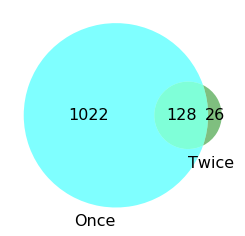

In [30]:
v = venn2([set(cupsDF.loc[cupsDF.occurrence_per_week == 1, 'cup_id'][0].tolist()), 
           set(cupsDF.loc[cupsDF.occurrence_per_week == 2, 'cup_id'][1].tolist())],
          set_labels=('Once', 'Twice'),
          set_colors=('cyan', 'green'),
          alpha=0.5
          )
v.get_label_by_id('A').set_color('black')
v.get_label_by_id('B').set_color('black')

for text in v.set_labels:
    text.set_fontsize(16)
for text in v.subset_labels:
    text.set_fontsize(16)

plt.show()

In [31]:
occurDF = groupDF.groupby(by=['cup_id', 'occurrence_per_week']).size().reset_index(name='num_weeks')
occurDF = occurDF.pivot(index='cup_id', columns='occurrence_per_week', values='num_weeks')
occurDF.columns.name = None
occurDF = occurDF.reset_index().rename(columns={1: 'once', 2: 'twice'})
occurDF.head()

,cup_id,once,twice
0,1008415089,1.0,NaN
1,1017030777,3.0,NaN
2,1017492318,2.0,NaN
3,1020298180,4.0,NaN
4,1026930637,3.0,NaN


In [32]:
# get number of cups used once in any week
once_only = len(occurDF[occurDF.twice.isna()])
# get number of cups used twice in any week
twice_only = len(occurDF[occurDF.once.isna()])
# get number of cups used once or twice in any week
once_or_twice = len(occurDF[occurDF.once.notna() & occurDF.twice.notna()])
print(once_only, twice_only, once_or_twice)

1022 26 128


In [33]:
days = []
for cup in saleDF.cup_id.unique():
    temp = saleDF[saleDF.cup_id == cup]

    if len(temp) > 1:
        for i in range(len(temp)-1):
            days.append((temp.iloc[i+1, 3] - temp.iloc[i, 3]) / to_timedelta(1, unit='D'))

In [34]:
# name of the dataset
group_labels = ['Cups reuse time']

fig = ff.create_distplot([np.array(days)], group_labels, show_rug=False, bin_size=1)
fig.update_layout(xaxis=dict(range=[-1, ceil(max(days))+1]))

fig.update_layout(
    title="Histogram with probability density curve for cups reuse time (Bin size: 1 day)",
    xaxis_title="Duration in days",
    yaxis_title="Probability density",
    xaxis = dict(tickmode = 'linear')
    )

fig.update_traces(marker=dict(line=dict(width=1,
                                        color='Black')),
                  nbinsx=ceil(max(days)), 
                  autobinx=True, 
                  selector={'type':'histogram'}
                  )

counts, bins = np.histogram(days, bins=range(0, ceil(max(days)), 1))
height = round(max(counts)/sum(counts),2)
percents = [int(round(count/len(days)*100)) for count in counts]

fig.add_trace(Scatter(
    x=[ceil(max(days))],
    y=[height],
    mode="text",
    text='Total durations: {}'.format(len(days)),
    textposition="top left",
    showlegend=False
))

fig.add_trace(Scatter(
    x=np.arange(0.5, ceil(max(days)), 1),
    y=[round(count/len(days),4)+0.005 for count in counts],
    mode="text",
    text=[str(percent) for percent in percents],
    textposition="top center",
    showlegend=False,
    hoverinfo='skip'
))


fig.show()

In [35]:
bin_days = 2

# name of the dataset
group_labels = ['Cups reuse time']

fig = ff.create_distplot([np.array(days)], group_labels, show_rug=False, bin_size=bin_days)
fig.update_layout(xaxis=dict(range=[-1, ceil(max(days))+1]))

fig.update_layout(
    title="Histogram with probability density curve for cups reuse time (Bin size: 2 days)",
    xaxis_title="Duration in days",
    yaxis_title="Probability density",
    xaxis = dict(tickmode = 'linear')
    )

fig.update_traces(marker=dict(line=dict(width=1,
                                        color='Black')),
                  nbinsx=ceil(max(days)/bin_days), 
                  autobinx=True, 
                  selector={'type':'histogram'}
                  )

counts, bins = np.histogram(days, bins=range(0, ceil(max(days))+1, bin_days))
height = round(max(counts)/sum(counts),2)/bin_days
percents = [int(round(count/len(days)*100)) for count in counts]

fig.add_trace(Scatter(
    x=[ceil(max(days))],
    y=[height],
    mode="text",
    text='Total durations: {}'.format(len(days)),
    textposition="top left",
    showlegend=False
))

fig.add_trace(Scatter(
    x=np.arange(1, ceil(max(days)), bin_days),
    y=[round(count/len(days),4)/bin_days +0.005 for count in counts],
    mode="text",
    text=[str(percent) + '%' for percent in percents],
    textposition="top center",
    showlegend=False,
    hoverinfo='skip'
))


fig.show()

In [36]:
#groupDF.groupby(by='cup_id')['occurrence_per_week'].apply(list).reset_index(name='new')
df = groupDF.pivot(index='cup_id', columns='week', values='occurrence_per_week').reset_index()
df.columns.name = None
df.head()

,cup_id,4,5,6,7,8,9,10,11
0,1008415089,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
1,1017030777,NaN,NaN,1.0,NaN,NaN,1.0,NaN,1.0
2,1017492318,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN
3,1020298180,NaN,NaN,NaN,1.0,NaN,1.0,1.0,1.0
4,1026930637,NaN,1.0,NaN,NaN,NaN,1.0,1.0,NaN


In [37]:
jsonObject = {}
nodesArray = []
linksArray = []
singleUse = {}

def updateNode(flag, weekStart, weekEnd=0):
            
    # update node for a cup's single use in all weeks
    if flag == 0:
        # find the existing node
        for index in range(len(nodesArray)):
            node = nodesArray[index]
            if node['week'] == weekStart:
                nodesArray[index]['single'] += 1
                break

    # update node for a cup's use in the same week (i.e used 2, 3 or more times in that week)
    elif flag == 1:
        # find the existing node
        for index in range(len(nodesArray)):
            node = nodesArray[index]
            if node['week'] == weekStart:
                # if not the first time, add 1
                if node['self'] != 0:
                    nodesArray[index]['self'] += 1
                    
                # if first time, add 2
                else:
                    nodesArray[index]['self'] += 2
                break

    # update nodes for a cup's use in 'start' and 'end' week
    else:
        # find the existing nodes
        for index in range(len(nodesArray)):
            node = nodesArray[index]
            if node['week'] == weekStart or node['week'] == weekEnd:
                if 'other' in node:
                    nodesArray[index]['other'] += 1
                else:
                    nodesArray[index]['other'] = 1

In [38]:
for node in list(df.columns[1:]):
    nodesArray.append({
        'week': node,
        'single': 0,
        'self': 0,
        'other': 0
    })
#count = 0
for index, row in df.iterrows():
    #print(row)
    start = None
    end = None
    for week in list(df.columns[1:]):
        if notna(row[week]):
            for uses in range(0, int(row[week])):
                if start == None:
                    start = week
                else:
                    end = week
        
                    # flag
                    found = False

                    # search for an existing link between start and end
                    for index in range(len(linksArray)):
                        link = linksArray[index]

                        # if link found, update count
                        if link['source'] == start and link['target'] == end:
                            found = True
                            linksArray[index]['count'] += 1
                            break

                    # if link is not found, create new link
                    if found == False:
                        linksArray.append({
                            'source': start,
                            'target': end,
                            'count' : 1
                    })
                    
                    if start == end:
                        # update node with week = start for self use denoted by flag = 1
                        updateNode(1, start)
                    else:
                        # update both nodes with week = start and week = end for 'start' (in past) week use 
                        # denoted by flag = 2
                        updateNode(2, start, end)
                    
                    start = week
    if end == None:
        # update node with week = start for single use denoted by flag = 0
        updateNode(0, start)
        
        # redundant...
        if str(start) in singleUse:
            singleUse[str(start)] += 1
        else:
            singleUse[str(start)] = 1
        # until here...

    #count += 1
    #if count == 10:
    #  break
#print('nodes', nodesArray)
#print('links', linksArray)
#print('singleuse', singleUse)

In [39]:
jsonObject['nodes'] = nodesArray
jsonObject['links'] = linksArray
jsonObject['singleUse'] = singleUse

with open('arcData.json', 'w') as fp:
    json.dump(jsonObject, fp, indent=4)

Reading and cleaning Return Data

In [18]:
# build dataframe
returnDF = DataFrame.from_dict(json_normalize(returnData), orient='columns')

# dropping columns 
returnDF = returnDF.drop(['scanned_at', 'bin_id', 'cafe_id', 'dishwasher_id', 'id'], axis=1)

# renaming columns
returnDF = returnDF.rename(columns={"scanned_at_melbourne_date_time.date": "return_date", "scanned_at_melbourne_date_time.time": "return_time"})

# merging date and time, converting new column to datetime64 datatype
returnDF['date_time_concat'] = returnDF['return_date'] + ' ' + returnDF['return_time']
returnDF['date_time'] = to_datetime(returnDF['date_time_concat'], dayfirst=True)
returnDF = returnDF.drop(['return_date', 'return_time', 'date_time_concat'], axis=1)

# filter to get records post 22nd Jan
returnDF = returnDF[returnDF['date_time'] >= '2020/01/22 00:00:00']
returnDF = returnDF.sort_values(by='date_time', ascending = True)

returnDF.head()

,cup_id,date_time
6243,3815501729,2020-01-22 14:55:40
6244,2397660595,2020-01-22 14:55:42
6245,4897580664,2020-01-22 14:55:43
6246,2486468654,2020-01-22 14:55:44
6247,4498550854,2020-01-22 14:55:45


In [19]:
returnDF['week'] =  returnDF.date_time.dt.week
returnDF.head()

C:\Users\ariha\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



,cup_id,date_time,week
6243,3815501729,2020-01-22 14:55:40,4
6244,2397660595,2020-01-22 14:55:42,4
6245,4897580664,2020-01-22 14:55:43,4
6246,2486468654,2020-01-22 14:55:44,4
6247,4498550854,2020-01-22 14:55:45,4


In [20]:
groupDF = returnDF.groupby(by=['cup_id', 'week']).size().reset_index(name='occurrence_per_week')
#groupDF.loc[groupDF['occurrence_per_week'] > 1, :]
groupDF.head()

,cup_id,week,occurrence_per_week
0,1008415089,4,1
1,1008415089,5,1
2,1008415089,6,1
3,1008415089,7,1
4,1008415089,9,2


In [21]:
cupsDF = groupDF.groupby('occurrence_per_week')['cup_id'].unique().reset_index()
cupsDF

,occurrence_per_week,cup_id
0,1,"[1008415089, 1017030777, 1017492318, 101932528..."
1,2,"[1008415089, 1012822375, 1017030777, 101932528..."
2,3,"[1251872932, 3961190543, 4736646430, 496833652..."


In [22]:
a = set(cupsDF.loc[cupsDF.occurrence_per_week == 1, 'cup_id'][0].tolist())
b = set(cupsDF.loc[cupsDF.occurrence_per_week == 2, 'cup_id'][1].tolist())
c = set(cupsDF.loc[cupsDF.occurrence_per_week == 3, 'cup_id'][2].tolist())

once = len(a - b - c)
twice = len(b - a - c)
thrice = len(c - a - b)

once_twice = len(a.intersection(b))
twice_thrice = len(b.intersection(c))
once_thrice = len(a.intersection(c))

once_twice_thrice = len(a.intersection(b).intersection(c))

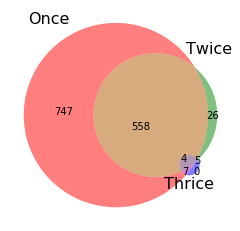

In [23]:
v = venn3(subsets=(once, twice, once_twice, thrice, once_thrice, twice_thrice, once_twice_thrice),
      set_labels=('Once', 'Twice', 'Thrice'),
      alpha=0.5
      )
v.get_label_by_id('A').set_color('black')
v.get_label_by_id('B').set_color('black')
v.get_label_by_id('C').set_color('black')

for text in v.set_labels:
    text.set_fontsize(16)
#for text in v.subset_labels:
#    text.set_fontsize(16)

plt.show()

In [24]:
days = []
for cup in returnDF.cup_id.unique():
    temp = returnDF[returnDF.cup_id == cup]

    if len(temp) > 1:
        for i in range(len(temp)-1):
            days.append((temp.iloc[i+1, 1] - temp.iloc[i, 1]) / to_timedelta(1, unit='D'))

In [25]:
# name of the dataset
group_labels = ['Cups reuse time']

fig = ff.create_distplot([np.array(days)], group_labels, show_rug=False, bin_size=1)
fig.update_layout(xaxis=dict(range=[-1, ceil(max(days))+1]))

fig.update_layout(
    title="Histogram with probability density curve for cups reuse time",
    xaxis_title="Duration in days",
    yaxis_title="Probability density",
    xaxis = dict(tickmode = 'linear')
    )

fig.update_traces(marker=dict(line=dict(width=1,
                                        color='Black')),
                  nbinsx=ceil(max(days)), 
                  autobinx=True, 
                  selector={'type':'histogram'}
                  )

counts, bins = np.histogram(days, bins=range(0, ceil(max(days)), 1))
height = round(max(counts)/sum(counts),2)
percents = [int(round(count/len(days)*100)) for count in counts]

fig.add_trace(Scatter(
    x=[ceil(max(days))],
    y=[height],
    mode="text",
    text='Total durations: {}'.format(len(days)),
    textposition="top left",
    showlegend=False
))

fig.add_trace(Scatter(
    x=np.arange(0.5, ceil(max(days)), 1),
    y=[round(count/len(days),4)+0.005 for count in counts],
    mode="text",
    text=[str(percent) for percent in percents],
    textposition="top center",
    showlegend=False,
    hoverinfo='skip'
))


fig.show()